<a href="https://colab.research.google.com/github/serg-kas/A-G-I-demo/blob/master/Model_VGG16_as_features_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analog Gauge Inspection

**Определение показаний аналогового стрелочного прибора.**

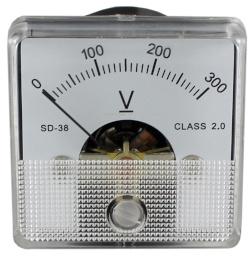

In [1]:
!git clone https://github.com/serg-kas/A-G-I-demo
%cd A-G-I-demo

Cloning into 'A-G-I-demo'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 123 (delta 65), reused 59 (delta 24), pack-reused 0
Receiving objects: 100% (123/123), 840.12 KiB | 14.74 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/A-G-I-demo


In [2]:
# Импорт библиотек
import numpy as np
import cv2 as cv
import os
import random
#
import utils as u 

from tensorflow.keras.models import Model 
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics.pairwise import cosine_similarity

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

Диапазон движение стрелки: от 0.77 до 2.37
Случайное показание прибора: 57
Размер картинки: (175, 511, 3)


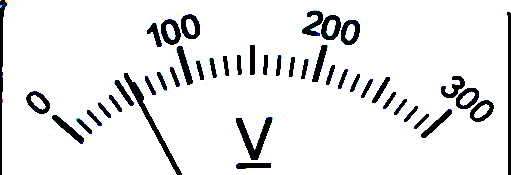

In [3]:
    # Подготовим изображение прибора (резайз и пр.)
    u.gauge_img_preparing()
    assert 'Voltmeter-Blank.jpg' in os.listdir('.')

    # Загружаем изображение прибора без стрелки
    img = cv.imread('Voltmeter-Blank.jpg')

    # Подготавливаем данные положения стрелки прибора
    # L - длинна стрелки
    # angle_0, angle_1  - углы крайних положений стрелки
    L, angle_0, angle_1 = u.gauge_needle_preparing(img)

    # Получаем случайное показание прибора
    img_example, r = u.get_random_measurement(img, L, angle_0, angle_1)
    print('Диапазон движение стрелки: от {:.2f} до {:.2f}'.format(angle_0, angle_1))
    print('Случайное показание прибора: {}'.format(int(300 * r)))
    print('Размер картинки: {}'.format(img_example.shape))
    
    cv2_imshow(img_example)

**Подготовим выборку из 60 картинок**

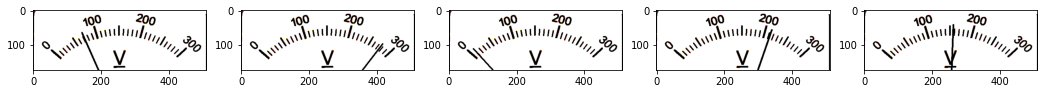

In [4]:
# Подготовим набор картинок
img = cv.imread('Voltmeter-Blank.jpg')
angles = np.linspace(angle_0, angle_1, num=60)

images = []
for i in range(angles.shape[0]):
  angle = angles[i]
  # print(angle) 
  curr_img = img.copy()
  curr_img = u.get_angle_measurement(curr_img, L, angle)
  images.append(curr_img)

# Примеры
fig, axs = plt.subplots(1, 5, figsize=(18, 5))                      
for i in range(5):                                                 
    plot_img = random.choice(images)     
    axs[i].imshow(plot_img)
plt.show() 

**Модель на базе VGG16 как экстрактор фич**

In [5]:
# скачиваем модель
# base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model = VGG16(weights='imagenet')


553476096/553467096 [==============================] - 3s 0us/step


In [6]:
# Экстрактор фич - это предобученная модель без последнего полносвязного слоя
feat_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# Получаем фичи картинок
features = []
for curr_img in images:
  img_to_pred = curr_img.copy()
  img_to_pred = cv.resize(img_to_pred, (224, 224), cv.INTER_LINEAR)
  img_to_pred = img_to_pred / 255. # preprocess_input ?
  img_to_pred = np.expand_dims(img_to_pred, axis = 0)
  pred = feat_extractor.predict(img_to_pred)[0]
  features.append(pred)


In [8]:
# Сохраним массивы
images_np = np.array(images)
feat_np = np.array(features)
#
np.save('angles', angles)
np.save('images', images_np)
np.save('feat', feat_np)

**Посмотрим предикт**

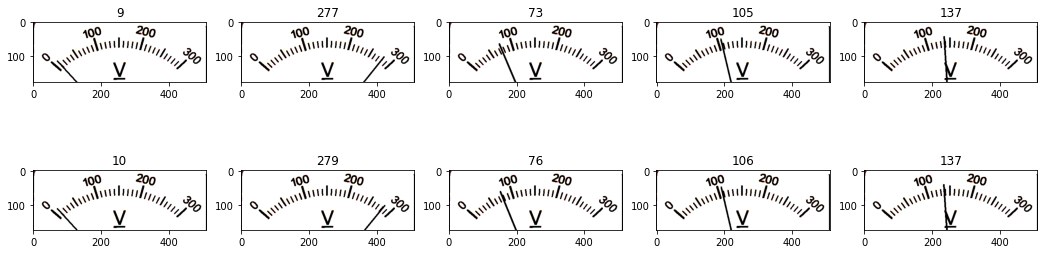

In [9]:
# 
img = cv.imread('Voltmeter-Blank.jpg')
L, angle_0, angle_1 = u.gauge_needle_preparing(img)

N = 5
fig, axs = plt.subplots(2, N, figsize=(18, 5))
for i in range(N):
  curr_img, curr_r = u.get_random_measurement(img.copy(), L, angle_0, angle_1)
  angle_r = angle_0 + curr_r * (angle_1 - angle_0)
  # подготовим изображение для отправки в модель
  img_to_pred = curr_img.copy()
  img_to_pred = cv.resize(img_to_pred, (224, 224), cv.INTER_LINEAR)
  img_to_pred = img_to_pred / 255. 
  img_to_pred = np.expand_dims(img_to_pred, axis = 0)
  pred = feat_extractor.predict(img_to_pred)
  # определяем наиболее близкую картинку (ее индекс)
  cosPred = cosine_similarity(pred, feat_np)
  pred_idx = np.argmax(cosPred)
  # 
  res_img = img.copy()
  res_angle = angles[pred_idx]
  res_img = u.get_angle_measurement(res_img, L, res_angle)
  res_r = (res_angle - angle_0) / (angle_1 - angle_0)

  # пересчитаем радианы в вольты
  curr_V = int(300 * curr_r)
  res_V = int(300 * res_r)

  axs[0,i].imshow(curr_img)
  axs[0,i].set_title(curr_V)
  axs[1,i].imshow(res_img)
  axs[1,i].set_title(res_V)

plt.show() 


Выполним 100 предиктов и посчитаем среднюю точность. 

Желательно получить точность не хуже половины деления шкалы, что составляет в данном случае 5В

In [10]:
# 
img = cv.imread('Voltmeter-Blank.jpg')
L, angle_0, angle_1 = u.gauge_needle_preparing(img)

acc_list = []  # список для подсчета точности

N = 100
for i in range(N):
  curr_img, curr_r = u.get_random_measurement(img.copy(), L, angle_0, angle_1)
  angle_r = angle_0 + curr_r * (angle_1 - angle_0)
  # подготовим изображение для отправки в модель
  img_to_pred = curr_img.copy()
  img_to_pred = cv.resize(img_to_pred, (224, 224), cv.INTER_LINEAR)
  img_to_pred = img_to_pred / 255. 
  img_to_pred = np.expand_dims(img_to_pred, axis = 0)
  pred = feat_extractor.predict(img_to_pred)
  # определяем наиболее близкую картинку (ее индекс)
  cosPred = cosine_similarity(pred, feat_np)
  pred_idx = np.argmax(cosPred)
  # 
  res_img = img.copy()
  res_angle = angles[pred_idx]
  res_img = u.get_angle_measurement(res_img, L, res_angle)
  res_r = (res_angle - angle_0) / (angle_1 - angle_0)

  # пересчитаем радианы в вольты
  curr_V = int(300 * curr_r)
  res_V = int(300 * res_r)

  acc_list.append(abs(curr_V - res_V))

acc_np = np.array(acc_list)
print('Средняя погрешность, В: {}'.format(acc_np.mean()))
print('Максимальная погрешность, В: {}'.format(acc_np.max()))


Средняя погрешность, В: 1.37
Максимальная погрешность, В: 4


При выборке из 60 картинок получилась средняя погрешность 1,37В, максимальная 4В

При выборке из 30 картинок получилась средняя погрешность 2,84В, максимальная 7В


